# Prework

In [61]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import scipy.ndimage as ndi
import pandas as pd
import os
import pathlib
import copy
import torch
import math

In [3]:
train_dir = '../input/prostate15/prostate158_train/prostate158_train'
train_csv = os.path.join(train_dir, 'train.csv')
train_valid_csv = os.path.join(train_dir, 'valid.csv')

test_dir = '../input/prostate15/prostate158_test/prostate158_test'
test_csv = os.path.join(test_dir, 'test.csv')

In [4]:
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(train_valid_csv)
test_df = pd.read_csv(test_csv)

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,24,train/024/t2.nii.gz,train/024/adc.nii.gz,train/024/dwi.nii.gz,train/024/t2_anatomy_reader1.nii.gz,NaN,train/024/empty.nii.gz,NaN,NaN
1,25,train/025/t2.nii.gz,train/025/adc.nii.gz,train/025/dwi.nii.gz,train/025/t2_anatomy_reader1.nii.gz,train/025/t2_tumor_reader1.nii.gz,train/025/adc_tumor_reader1.nii.gz,NaN,train/025/adc_tumor_reader2.nii.gz
2,26,train/026/t2.nii.gz,train/026/adc.nii.gz,train/026/dwi.nii.gz,train/026/t2_anatomy_reader1.nii.gz,NaN,train/026/empty.nii.gz,NaN,NaN
3,27,train/027/t2.nii.gz,train/027/adc.nii.gz,train/027/dwi.nii.gz,train/027/t2_anatomy_reader1.nii.gz,train/027/t2_tumor_reader1.nii.gz,train/027/adc_tumor_reader1.nii.gz,NaN,train/027/adc_tumor_reader2.nii.gz
4,28,train/028/t2.nii.gz,train/028/adc.nii.gz,train/028/dwi.nii.gz,train/028/t2_anatomy_reader1.nii.gz,NaN,train/028/empty.nii.gz,NaN,NaN


In [ ]:
def remove_compression_suffix(df):
    columns = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 't2_anatomy_reader2', 'adc_tumor_reader2']
    df[columns] = df[columns].map(lambda v: '.'.join(x for x in v.split('.')[:-1]) if isinstance(v, str) else v)
    return df

In [65]:
train_df = remove_compression_suffix(train_df)
valid_df = remove_compression_suffix(valid_df)
test_df = remove_compression_suffix(test_df)
train_df.head()

# Prostate158 - Eploratory data analysis

In [ ]:
train_df.head()

## Columns' description&ast;
* **ID** – patient MRI identificator
* **t2** – t2 sequence in NIfTI format
* **adc** – ADC sequence in NIfTI format
* **dwi** – DWI sequence in NIfTI format
* **t2_anatomy_reader1** – Anatomy segmentation of reader 1
* **t2_anatomy_reader2** – Anatomy segmentation of reader 2&ast;&ast;
* **t2_tumor_reader1** – Tumor segmentation of reader 1
* **adc_tumor_reader1** – Tumor segmentation of reader 1
* **adc_tumor_reader2** – Tumor segmentation of reader 2

<details>
    <summary>Abbreviations</summary>
    - <a href="https://radiopaedia.org/articles/apparent-diffusion-coefficient-1">What is Apparent diffusion coefficient?</a>
    - <a href="https://radiopaedia.org/articles/apparent-diffusion-coefficient-1">What is Diffusion-weighted imaging?</a>
</details>

###### &ast;Based on https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9679750/pdf/main.pdf, &ast;&ast;own caption


## Missing data per dataset part

In [16]:
for label, df in {'Train Set': train_df, 'Training Validation Set': valid_df, 'Test Set': test_df}.items():
    na_vals = pd.isna(df).sum()
    percent_missing = na_vals / df.shape[0]
    percent_missing = percent_missing.apply(lambda x: f"{x:.2%}")
    print(label)
    print(pd.DataFrame({'count missing': na_vals, 'percent_missing': percent_missing}).sort_values(by='count missing', ascending=False))
    print('\n' * 2)

Train Set
                    count missing percent_missing
t2_anatomy_reader2            119         100.00%
adc_tumor_reader2              62          52.10%
t2_tumor_reader1               49          41.18%
ID                              0           0.00%
t2                              0           0.00%
adc                             0           0.00%
dwi                             0           0.00%
t2_anatomy_reader1              0           0.00%
adc_tumor_reader1               0           0.00%



Training Validation Set
                    count missing percent_missing
t2_anatomy_reader2             20         100.00%
adc_tumor_reader2              10          50.00%
t2_tumor_reader1                8          40.00%
ID                              0           0.00%
t2                              0           0.00%
adc                             0           0.00%
dwi                             0           0.00%
t2_anatomy_reader1              0           0.00%
adc_tumor_rea

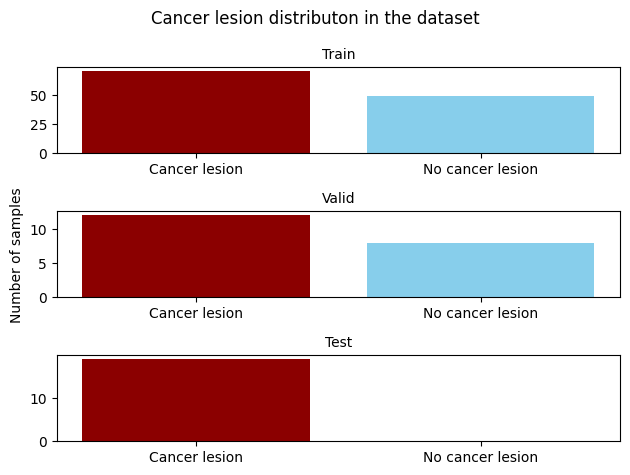

In [17]:
has_tumor_file = lambda x: type(x) is str
train_counts = train_df['t2_tumor_reader1'].map(has_tumor_file).value_counts(bins=2)
valid_counts = valid_df['t2_tumor_reader1'].map(has_tumor_file).value_counts(bins=2)
test_counts = test_df['t2_tumor_reader1'].map(has_tumor_file).value_counts(bins=2)

fig, ax = plt.subplots(3, 1)
bar_colors = ['darkred', 'skyblue']

labels = ['Cancer lesion', 'No cancer lesion']
ax[0].bar(labels, train_counts, color=bar_colors)
ax[0].set_title('Train', fontsize=10)

ax[1].bar(labels, valid_counts, color=bar_colors)
ax[1].set_ylabel('Number of samples')
ax[1].set_title('Valid', fontsize=10)

ax[2].bar(labels, test_counts, color=bar_colors)
ax[2].set_title('Test', fontsize=10)

plt.suptitle('Cancer lesion distributon in the dataset')
plt.tight_layout()
plt.show()

More than half of the cases of the training data seems to have cancerous lesions

## Samples visualisation

In [7]:
def load_nii(f_name, dir=train_dir):
    if (isinstance(f_name, str) == False):
        raise Exception(f'Invalid filepath "{f_name}"" is not a string')
    img = nib.load(os.path.join(dir, f_name))
    data = img.get_fdata()
    return (img, data)

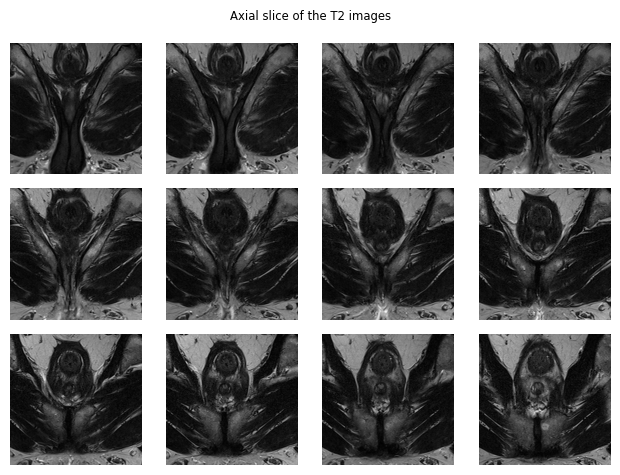

In [8]:
t2, t2_data = load_nii(train_df.iloc[2]['t2'])
t2_slice = t2_data[:, :]
img_count = t2_slice.shape[-1]
cols = 4
rows = img_count // cols + (0 if img_count % cols == 0 else 1)
fig, axs = plt.subplots(min(rows, 3), cols)
for i in range(min(img_count, 12)):
    axs.flat[i].imshow(ndi.rotate(t2_slice[:,:,i], 90), cmap='gray')
    axs.flat[i].axis('off')
    
fig.suptitle('Axial slice of the T2 images', size='small')
plt.axis('off')
plt.tight_layout()
plt.show()

In contrast to "classic" images made of 2D pixels, MRI scans usually consist of voxels. A voxel can be imagined as a three-dimensional pixel.

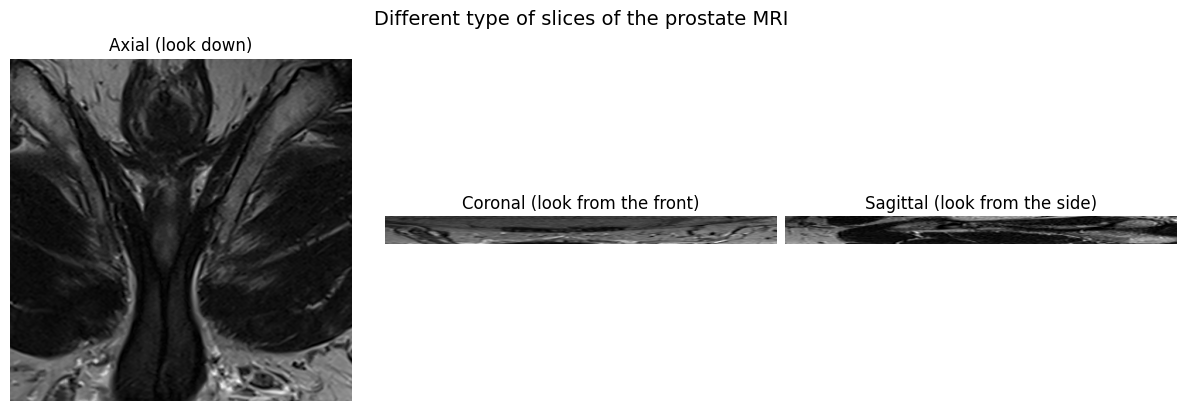

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (12,4), constrained_layout=True)

ax[0].set_title('Axial (look down)')
ax[0].imshow(np.rot90(t2_data[:,:,0]), cmap='gray')
ax[0].axis('off')

ax[1].set_title('Coronal (look from the front)')
ax[1].imshow(np.rot90(t2_data[:,0,:]), cmap='gray')
ax[1].axis('off')

ax[2].set_title('Sagittal (look from the side)')
ax[2].imshow(np.rot90(t2_data[0,:,:]), cmap='gray')
ax[2].axis('off')

fig.suptitle('Different type of slices of the prostate MRI', fontsize=14)
plt.show()

In [27]:
def process_slice(data, selected_image, mask=False):
    img_slice = data[:, :, selected_image]
    img_slice = np.rot90(img_slice)
    if mask:
        img_slice = np.ma.masked_where(img_slice == 0, img_slice)
    return img_slice

def plot_images(axs, titles, base_img, overlay_imgs=None, overlay_alpha=0.5, cmap='gray', overlay_cmap='autumn'):
    for ax, title, overlay in zip(axs, titles, overlay_imgs or (None for _ in axs)):
        ax.set_title(title, fontsize=9)
        ax.imshow(base_img, cmap=cmap)
        if overlay is not None:
            ax.imshow(overlay, alpha=overlay_alpha, cmap=overlay_cmap)
        ax.axis('off')

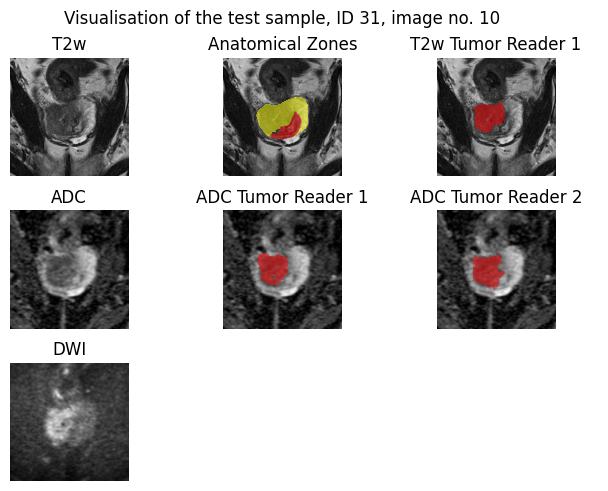

In [10]:
CASE = 7
SET = train_df
SELECTED_IMG = 10

data_files = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2']
data = {key: load_nii(SET.iloc[CASE][key])[1] for key in data_files}

t2_slice, dwi_slice, adc_slice = [process_slice(data[fname], SELECTED_IMG) for fname in ('t2', 'dwi', 'adc')]
t2_ar1_slice, t2_tr1_slice, adc_tr1_slice, adc_tr2_slice = [process_slice(data[fname], SELECTED_IMG, mask=True) for fname in ('t2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2')]

fig = plt.figure(constrained_layout=True)
fig.suptitle(f'Visualisation of the train sample, ID {SET.iloc[CASE]["ID"]}, image no. {SELECTED_IMG}')
subfigs = fig.subfigures(3, 1)

axsTop = subfigs[0].subplots(1, 3)
plot_images(axsTop, ['T2w', 'Anatomical Zones', 'T2w Tumor Reader 1'], t2_slice, [None, t2_ar1_slice, t2_tr1_slice])

axsMiddle = subfigs[1].subplots(1, 3)
plot_images(axsMiddle, ['ADC', 'ADC Tumor Reader 1', 'ADC Tumor Reader 2'], adc_slice, [None, adc_tr1_slice, adc_tr2_slice])

axsBottom = subfigs[2].subplots(1, 3)
plot_images(axsBottom, ['DWI'], dwi_slice)
for ax in axsBottom[1:]:
    ax.axis('off')

plt.show()

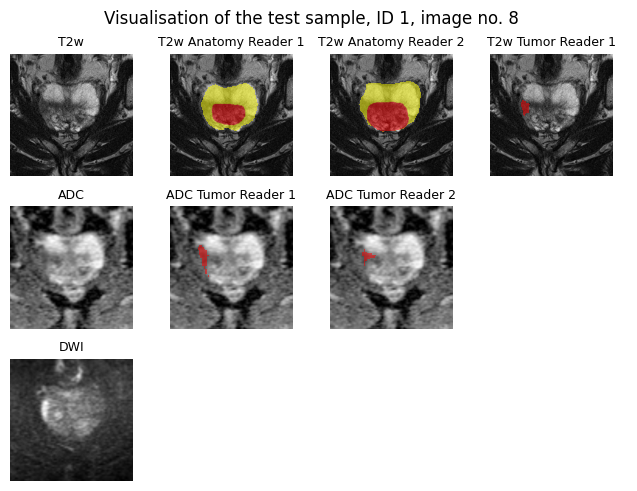

In [33]:
CASE = 0
SET = test_df
SELECTED_IMG = 8

data_files = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_anatomy_reader2', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2']
data = {key: load_nii(SET.iloc[CASE][key], dir=test_dir)[1] for key in data_files}

t2_slice, dwi_slice, adc_slice = [process_slice(data[fname], SELECTED_IMG) for fname in ('t2', 'dwi', 'adc')]
t2_ar1_slice, t2_ar2_slice, t2_tr1_slice, adc_tr1_slice, adc_tr2_slice = [process_slice(data[fname], SELECTED_IMG, mask=True) for fname in ('t2_anatomy_reader1', 't2_anatomy_reader2', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2')]

fig = plt.figure(constrained_layout=True)
fig.suptitle(f'Visualisation of the test sample, ID {SET.iloc[CASE]["ID"]}, image no. {SELECTED_IMG}')
subfigs = fig.subfigures(3, 1)

axsTop = subfigs[0].subplots(1, 4)
plot_images(axsTop, ['T2w', 'T2w Anatomy Reader 1', 'T2w Anatomy Reader 2', 'T2w Tumor Reader 1'], t2_slice, [None, t2_ar1_slice, t2_ar2_slice, t2_tr1_slice])

axsMiddle = subfigs[1].subplots(1, 4)
plot_images(axsMiddle, ['ADC', 'ADC Tumor Reader 1', 'ADC Tumor Reader 2'], adc_slice, [None, adc_tr1_slice, adc_tr2_slice])
for ax in axsMiddle[3:]:
    ax.axis('off')

axsBottom = subfigs[2].subplots(1, 4)
plot_images(axsBottom, ['DWI'], dwi_slice)
for ax in axsBottom[1:]:
    ax.axis('off')

plt.show()

# Pipeline setup – nnU-Net

## Installing NVIDIA Apex (GPU Required) / everytime notebook runs
*(it takes around 15-25 minutes)*

In [3]:
!git clone https://github.com/NVIDIA/apex

Cloning into 'apex'...
remote: Enumerating objects: 11809, done.
remote: Counting objects: 100% (3902/3902), done.
remote: Compressing objects: 100% (711/711), done.
remote: Total 11809 (delta 3455), reused 3405 (delta 3185), pack-reused 7907
Receiving objects: 100% (11809/11809), 15.58 MiB | 29.87 MiB/s, done.
Resolving deltas: 100% (8257/8257), done.


In [1]:
os.chdir(os.path.join(os.getcwd(), 'apex'))
!pip install -v --disable-pip-version-check --no-cache-dir --no-build-isolation --config-settings "--build-option=--cpp_ext" --config-settings "--build-option=--cuda_ext" ./
os.chdir(os.path.join(os.getcwd(), '..'))
os.getcwd()

Using pip 23.3.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
Processing /kaggle/working/apex
  Running command Preparing metadata (pyproject.toml)

   If your intention is to cross-compile, this is not an error.
  By default, Apex will cross-compile for Pascal (compute capabilities 6.0, 6.1, 6.2),
  Volta (compute capability 7.0), Turing (compute capability 7.5),
  and, if the CUDA version is >= 11.0, Ampere (compute capability 8.0).
  If you wish to cross-compile for a single specific architecture,
  export TORCH_CUDA_ARCH_LIST="compute capability" before running setup.py.



  torch.__version__  = 2.1.2+cpu


  Traceback (most recent call last):
    File "/opt/conda/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
      main()
    File "/opt/conda/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs']

'/kaggle/working'

Check if installation was successful

In [3]:
from apex import amp
dir(amp)

## [Installing nnU-Net](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/installation_instructions.md#installation-instructions)
*It should take no more than 3 minutes*

In [34]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
os.chdir('/kaggle/working')
os.chdir(os.path.join(os.getcwd(), 'nnUNet'))
!pip install -e .
# The line below is optional – plots for the training
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git
os.chdir(os.path.join(os.getcwd(), '..'))

Cloning into 'nnUNet'...
remote: Enumerating objects: 12730, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12730 (delta 6), reused 8 (delta 4), pack-reused 12717
Receiving objects: 100% (12730/12730), 7.70 MiB | 12.89 MiB/s, done.
Resolving deltas: 100% (9762/9762), done.
Obtaining file:///kaggle/working/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00

## [Setup variables for the nnU-Net](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md)

In [75]:
os.chdir('/kaggle/working/')
if (os.getcwd() != '/kaggle/working'):
    raise Exception(f'Not in the working catalog! Current catalog: {os.getcwd()}')

raw_dataset_catalog = os.path.join(pathlib.Path(os.getcwd()).parent.absolute(), 'input', 'nnunet')
# Task should be in format TaskXXX_\s+; 
task_name = 'Task158_Prostate'
# Not persisted after the session is closed!
preprocessed_catalog = os.path.join(pathlib.Path(os.getcwd()).parent.absolute(), 'tmp', 'preprocessed')
# There the weights of the model will be stored
results_catalog = os.path.join(os.getcwd(), 'results')

os.environ['nnUNet_raw'] = raw_dataset_catalog
os.environ['nnUNet_preprocessed'] = preprocessed_catalog
os.environ['nnUNet_results'] = results_catalog
!echo nnUNet_raw = $nnUNet_raw
!echo nnUNet_preprocessed = $nnUNet_preprocessed
!echo nnUNet_results = $nnUNet_results

nnUNet_raw = /kaggle/input/nnunet
nnUNet_preprocessed = /kaggle/tmp/preprocessed
nnUNet_results = /kaggle/working/results


## Convert the dataset to decathlon like structure (only once)

In [83]:
if not os.path.exists(os.path.join(raw_dataset_catalog, task_name)):
    tmp_dataset_catalog = os.path.join('kaggle', 'tmp', task_name)
    os.mkdir(os.path.join('kaggle', 'tmp'))
    os.mkdir(tmp_dataset_catalog)
    print(os.list(os.getcwd(), '..', 'tmp'))

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/tmp'

In [76]:
if not os.path.exists(os.path.join(raw_dataset_catalog, task_name)):
    raise Exception(f'No data for the nnU-Net in: {os.path.join(raw_dataset_catalog, task_name)}')

Exception: No data for the nnU-Net in: /kaggle/input/nnunet/Task158_Prostate